In [2]:
import datetime
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from datasets import get_datasets, get_shiller
import matplotlib.pyplot as plt
import random

time_horizon = 40

data = get_datasets()
data['returns_with_dividends'] = data['simple_return'] + data['dividend_return']

[*********************100%***********************]  1 of 1 completed


In [4]:
# Define the investment horizon
time_horizon = 40

# Define the horizons and the number of portfolios
horizons = np.arange(1, time_horizon+1, 1)
n_portfolios = len(data) - (time_horizon * 12) + 1

# Create arrays to store the portfolio results
cum_market_returns_distributions = np.zeros((len(horizons), n_portfolios))
cum_risk_free_returns_distributions = np.zeros((len(horizons), n_portfolios))
cum_dividends_returns_distributions = np.zeros((len(horizons), n_portfolios))
starting_dates = []

# Loop through each investment horizon
for h_idx, horizon in enumerate(horizons):
    # Calculate the number of months in the specified time horizon
    months_in_horizon = horizon * 12

    # Loop through each portfolio and calculate the cumulative returns
    for i in range(n_portfolios):
        start_idx = i
        end_idx = start_idx + months_in_horizon

        market_returns = data.loc[start_idx:end_idx-1, 'simple_return'].values
        risk_free_returns = data.loc[start_idx:end_idx-1, 'returns_rf'].values
        dividends_returns = data.loc[start_idx:end_idx-1, 'returns_with_dividends'].values

        cum_market_returns_portfolios = np.prod(1 + market_returns) - 1
        cum_risk_free_returns_portfolios = np.prod(1 + risk_free_returns) - 1
        cum_dividends_returns_portfolios = np.prod(1 + dividends_returns) - 1

        # Store the cumulative return distributions for the current investment horizon
        cum_market_returns_distributions[h_idx, i] = cum_market_returns_portfolios
        cum_risk_free_returns_distributions[h_idx, i] = cum_risk_free_returns_portfolios
        cum_dividends_returns_distributions[h_idx, i] = cum_dividends_returns_portfolios
        starting_dates.append(data.loc[start_idx, 'Date'])

# Convert the list of starting dates to a numpy array
starting_dates = np.array(starting_dates)

In [14]:
import numpy as np
import pandas as pd

# Define arrays to store results
mean_annualized_risk_free = np.zeros(len(horizons))
mean_cumulative_risk_free = np.zeros(len(horizons))

mean_cumulative_returns = np.zeros(len(horizons))
mean_annualized_returns = np.zeros(len(horizons))

std_cumulative_returns = np.zeros(len(horizons))
std_annualized_returns = np.zeros(len(horizons))

# Avoid division by zero
epsilon = 1e-8

def calculate_annualized_returns(cumulative_returns, horizon):
    annualized_return = ((cumulative_returns + 1) ** (1 / horizon)) - 1
    return annualized_return

for h_idx, horizon in enumerate(horizons):

    cumulative_returns = cum_dividends_returns_distributions[h_idx]
    cumulative_risk_free = cum_risk_free_returns_distributions[h_idx]

    annualized_returns = calculate_annualized_returns(cumulative_returns, horizon)
    annualized_risk_free = calculate_annualized_returns(cumulative_risk_free, horizon)

    mean_annualized_risk_free[h_idx] = np.mean(annualized_risk_free)
    mean_cumulative_risk_free[h_idx] = np.mean(cumulative_risk_free)

    mean_cumulative_returns[h_idx] = np.mean(cumulative_returns)
    mean_annualized_returns[h_idx] = np.mean(annualized_returns)
   
    std_cumulative_returns[h_idx] = np.std(cumulative_returns)
    std_annualized_returns[h_idx] = np.std(annualized_returns)

# Convert returns to DataFrame
statistics = pd.DataFrame({
    'Cumulative Risk Free Returns': mean_cumulative_risk_free,
    'Average Annualized Risk Free Return': mean_annualized_risk_free,
   
    'Mean Cumulative Returns': mean_cumulative_returns,
    'Mean Annualized Returns': mean_annualized_returns,
    
    'Std Dev of Cumulative Returns': std_cumulative_returns,
    'Std Dev of Annualized Returns': std_annualized_returns,
}, index=horizons)




0.09090355866207106 0.22835663066350625
0.08496942713835148 0.15089018721997358
0.08021985742879867 0.116290662594728
0.07563811338456111 0.09494075283592986
0.07147869605331209 0.08023497226016968
0.06661280016287147 0.068246038645949
0.0642963519152771 0.06098149856064527
0.06528817703841994 0.05792486013577604
0.0666285225849152 0.05573583995184007
0.06739316752811586 0.053483914573938335
0.06932386783618466 0.05245946898707266
0.06931465800359954 0.050219428158442374
0.06858075286798737 0.047737131745105674
0.06622356074565589 0.04441585153056339
0.06462625281451939 0.04187250841470442
0.06357085158915293 0.03987936499110048
0.0637813508608518 0.038817048234504534
0.06399924294610182 0.03785253898387171
0.0622615059696392 0.03584051339216153
0.05946350645109172 0.03336015609391263
0.056266065421704814 0.030802592121233374
0.0535233393902827 0.02862515871098399
0.05132277877011493 0.026843305448649254
0.04814499979723319 0.024648999959449854
0.043838233354047906 0.021988300009195702

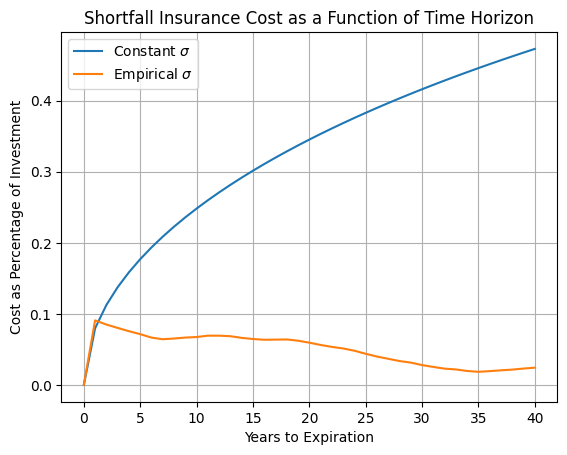

In [48]:

#BODIE 1995
import numpy as np
from scipy.stats import norm

def black_scholes_put_option_ratio(sigma, T):
    """
    The Black-Scholes model for the cost of a put option as a ratio of the underlying stock price.

    Args:
        sigma (float): standard deviation of the annualized continuously compounded rate of return on the stock
        T (float): time to maturity of the option in years

    Returns:
        P_S (float): the cost of the put option as a ratio of the underlying stock price
    """
    # Calculate d1 and d2
    d1 = sigma * np.sqrt(T) / 2
    d2 = -sigma * np.sqrt(T) / 2

    # Calculate N(d1) and N(d2)
    N_d1 = norm.cdf(d1)
    N_d2 = norm.cdf(d2)

    # Calculate P/S
    P_S = N_d1 - N_d2

    return P_S
#selected_statistics = statistics.loc['Std Dev of Annualized Returns']
real_stdev = statistics['Std Dev of Annualized Returns']

constant_sigma = 0.2

put_cost_constant = [0]
put_cost_real = [0]

for T, sigma in enumerate(real_stdev):
    T+=1
    P_S = black_scholes_put_option_ratio(constant_sigma, T)
    P_S_real = black_scholes_put_option_ratio(sigma, T)
    print(P_S_real,sigma)
    put_cost_constant.append(P_S)
    put_cost_real.append(P_S_real)

T_and_stdev = [
    (1, 0.2284),
    (5, 0.0802),
    (10, 0.0535),
    (15, 0.0419),
    (20, 0.0334),
    (30, 0.0128),
    (40, 0.0096)
]


# Generate the table in LaTeX format
table = "\\begin{tabular}{ccc}\n"
table += "\\toprule\n"
table += "Horizon & Shortfall insurance cost & Shortfall insurance cost \\\\\n"
table += "& \\multicolumn{2}{c}{(in ratio to the underlying stock price)} \\\\\n"
table += "\\cmidrule(lr){2-3}\n"
table += "& Constant $\\sigma$ & Variable $\\sigma$ \\\\\n"
table += "\\midrule\n"

for T, sigma in T_and_stdev:
    P_S = round(black_scholes_put_option_ratio(constant_sigma, T)*100,2)
    P_S_real = round(black_scholes_put_option_ratio(sigma, T)*100,2)
    table += f"{T} & {P_S:.4f} & {P_S_real:.4f} \\\\\n"

table += "\\bottomrule\n"
table += "\\end{tabular}"

print(table)


plt.plot(put_cost_constant, label='Constant $\sigma$')
plt.plot(put_cost_real, label='Empirical $\sigma$')
plt.xlabel('Years to Expiration')
plt.ylabel('Cost as Percentage of Investment')
plt.title('Shortfall Insurance Cost as a Function of Time Horizon')
plt.legend()
plt.grid(True)
plt.savefig('portfolios/shortfall_insurance')
plt.show()